# 1D Matern optimal localisation

The Matern process is given by the SPDE
$$
(\kappa^2 - \Delta)^\alpha X_t = \mathcal{W}
$$
We will consider the 1D version with $\alpha=1.0$.

In [1]:
import numpy as np
import scipy as sp
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve, solve_triangular
import networkx as nx
from graphite_maps.precision_estimation import fit_precision_cholesky, precision_to_graph

We will measure the KLD between the true distribution to the Matern process, $P$, and estimated distributions in EnIF and covarianse-localised EnKFs

In [61]:
def logdet_cholesky(A):
    L = cho_factor(A, lower=True)[0]
    logdet = 2 * np.sum(np.log(np.diag(L)))
    return logdet

def kldiv_mvn_cholesky(mu1, Sigma1, mu2, Sigma2):
    """
    Compute the Kullback-Leibler divergence between two multivariate normal distributions
    using Cholesky decomposition for numerically stable log-determinant computation.

    See https://statproofbook.github.io/P/mvn-kl.html for MVN KLD computation.
    
    Parameters:
    - mu1: Mean vector of the first distribution (numpy array)
    - Sigma1: Covariance matrix of the first distribution (numpy array)
    - mu2: Mean vector of the second distribution (numpy array)
    - Sigma2: Covariance matrix of the second distribution (numpy array)
    
    Returns:
    - KLD: The Kullback-Leibler divergence (scalar)
    """
    
    # Difference in means
    diff_mu = mu2 - mu1
    
    # Inverse of Sigma2 using Cholesky decomposition
    Sigma2_chol = cho_factor(Sigma2, lower=True)
    Sigma2_inv_mu_diff = cho_solve(Sigma2_chol, diff_mu)
    
    # Mahalanobis distance between the means
    mahalanobis_term = np.dot(diff_mu.T, Sigma2_inv_mu_diff)
    
    # Trace of Sigma2_inv * Sigma1
    Sigma2_inv_Sigma1 = cho_solve(Sigma2_chol, Sigma1)
    tr_term = np.trace(Sigma2_inv_Sigma1)
    
    # Log determinant terms using Cholesky-based logdet calculation
    logdet_Sigma1 = logdet_cholesky(Sigma1)
    logdet_Sigma2 = logdet_cholesky(Sigma2)
    
    # Dimensionality of the mean vectors
    d = len(mu1)
    
    # Final KLD formula
    kld = 0.5 * (mahalanobis_term + tr_term - logdet_Sigma1 + logdet_Sigma2 - d)
    
    return kld


The solution to the Matern SPDE is multivariate Gaussian

In [62]:
# Correct covariance function for Matern SPDE with exponent 1/2
def cov_stationary(h):
    # ou: dx = alpha(beta - x)dt + sigma dW_t -- dx = -\alpha x dt + dW
    # matern: (kappa**2 - Delta)**(1/2) x = W -- (1.0**2 - Delta)**(1/2) x = W
    # sigma_matern = sigma_ou / (2 * alpha_ou)
    # kappa_matern = alpha_ou^{-1} = 1.0
    return np.exp(-np.abs(h)) / 2.0

def cov_matrix_matern(grid):
    p = len(grid)
    cov_matrix = np.zeros((p,p))
    for i in range(p):
        for j in range(p):
            cov_matrix[i,j] = cov_stationary(grid[j] - grid[i])
    return cov_matrix

def P_analytical(grid):
    p = len(grid)
    mu = np.zeros(p)
    cov = cov_matrix_matern(grid)
    return mu, cov

We employ covarianse localisation with a Gaussian kernel

In [63]:
def covariance_localisation(grid, radius_of_influence=1.0):
    """
    Computes the covariance matrix k(s,t) = exp(-nu * (s - t)^2) 
    for all combinations of s, t in the given grid.

    Parameters:
    - grid: 1D numpy array or list of points.
    - radius_of_influence: The scaling parameter controlling the spread of the covariance (default is 1.0).

    Returns:
    - localisation_factors: The localisation factors (2D numpy array) of shape (len(grid), len(grid)).
    """
    grid = np.array(grid)
    diff_matrix = grid[:, None] - grid[None, :]
    localisation_factors = np.exp(-radius_of_influence * diff_matrix**2)
    return localisation_factors

We will compare EnIF and localised EnKF

In [64]:
def Q_ensemble_smoother(U):
    mu = U.mean(axis=0)
    cov_sample = np.cov(U,rowvar=False)
    return mu, cov_sample

def Q_localised_ensemble_smoother(U, grid, radius_of_influence):
    mu, cov_sample = Q_ensemble_smoother(U)
    localisation = covariance_localisation(grid, radius_of_influence)
    localised_cov = localisation * cov_sample
    return mu, localised_cov

def create_ar_graph(p):
    G = nx.Graph()
    # vertices
    for i in range(p):
        # edges
        G.add_node(i)
        # vertices
        for j in range(i+1, min(i + 1 + 1, p)):
            G.add_edge(i, j)
    return G

def Q_ensemble_information_filter(U, G):
    mu = U.mean(axis=0)
    prec_est, Graph_C, perm_compose, P_rev, P_order = fit_precision_cholesky(U, G, verbose_level=0, lambda_l2 = 0.0)
    cov = np.linalg.inv(prec_est.A)
    return mu, cov

We iterate through different values of radius of influence

In [66]:
n_radi = 30
radi = np.exp(np.linspace(-10, np.log(100000), num=n_radi))
kld_localised_es = np.zeros(n_radi)

# Fix resolution
p = 400 # max in resolution experiment
T = 10
dt = T / p
time = np.arange(0, T, dt)

# the true process
n = 1000
mu_true, cov_true = P_analytical(time)
U = np.random.multivariate_normal(mu_true, cov_true, size=n)

# The enif solution
G_u = create_ar_graph(p)
mu_enif, cov_enif = Q_ensemble_information_filter(U, G_u)
kld_enif = kldiv_mvn_cholesky(mu_true, cov_true, mu_enif, cov_enif)

for i, radius in enumerate(radi):
    mu_local_es, cov_local_es = Q_localised_ensemble_smoother(U, time, radius)
    kld_localised_es[i] = kldiv_mvn_cholesky(mu_true, cov_true, mu_local_es, cov_local_es)

Learning precision Cholesky factor row-by-row: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 1240.78it/s]


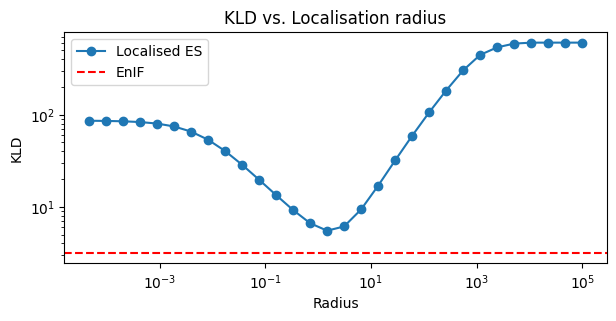

In [67]:
plt.figure(figsize=(7, 3))

# Plot KLD vs radi on a log x-axis
plt.plot(radi, kld_localised_es, label='Localised ES', marker='o')

# Set x-axis to be logarithmic
plt.xscale('log')
plt.yscale("log")

# Add a horizontal line at kld_enif
plt.axhline(y=kld_enif, color='r', linestyle='--', label=f'EnIF')

# Add labels and legend
plt.xlabel('Radius')
plt.ylabel('KLD')
plt.title('KLD vs. Localisation radius')
plt.legend()

if True:
    plt.savefig("kld_vs_localisation_radius.pdf", format='pdf', bbox_inches='tight')

plt.show()
plt.close()